# Data Preparation

This notebook cleans and prepares the data for training, validation, and testing.

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pickle
import glob
import PIL

### Filter out filler pages

Remove filler pages that do not contain sheet music information (e.g. title, foreword).  The file filler.txt indicates which pages are filler.

In [3]:
def getFillerList(filler_file, feat_dir):
    d = {} # list of pages to remove
    with open(filler_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) > 1:
                relpath = parts[0] # e.g. Bach/00748
                scoreID = os.path.basename(relpath) # e.g. 00748
                removeField = parts[1].strip('"') # e.g. "0,1,-2,-1" or "r" or "rl"
                numPages = getNumPages(relpath, feat_dir)
                if removeField == 'r' or removeField == 'rl': # remove all pages
                    for pkl_file in glob.glob('{}/{}/*.pkl'.format(feat_dir, parts[0])):
                        pageID = os.path.splitext(os.path.basename(pkl_file))[0] # e.g. 00822-3
                        d[pageID] = 1
                else:
                    for pageNumStr in removeField.split(','):
                        pageNum = int(pageNumStr)
                        if pageNum < 0:
                            pageID = '{}-{}'.format(scoreID, numPages + pageNum)
                            d[pageID] = 1
                        else:
                            pageID = '{}-{}'.format(scoreID, pageNum)
                            d[pageID] = 1
    return d

In [4]:
def getNumPages(relpath, indir):
    numPages = len(glob.glob('{}/{}/*.pkl'.format(indir, relpath)))
    return numPages

In [5]:
def getNonFillerFeatures(filler_file, feat_dir):
    '''
    Collect bootleg score features from all pages that are (a) not filler and (b) have a valid 
    bootleg score matrix.
    '''
    
    filler = getFillerList(filler_file, feat_dir)
    feats = {}
    
    for pieceDir in glob.glob('{}/*/*/'.format(feat_dir)): # e.g. score_feat/Bach/00748/
        
        pieceID = pieceDir.split('/')[-2]
        composer = pieceDir.split('/')[-3]
        accum = [] # features from all pages in this score (or None if filler/no features extracted)
        numPages = len(glob.glob('{}/*.pkl'.format(pieceDir)))
        
        for i in range(numPages):
            
            pkl_file = '{}/{}-{}.pkl'.format(pieceDir, pieceID, i)
            pageID = '{}-{}'.format(pieceID, i) # e.g. 00748-2
            if pageID in filler: # filler page, skip
                accum.append(None)
                continue
            with open(pkl_file, 'rb') as f:
                bscore = pickle.load(f)['bscore']
            if bscore is None: # if None, no features were computed
                accum.append(None)
            else:
                accum.append(bscore == 1) # convert from float to bool to compress memory
        
        if len(accum) > 0:
            feats[pieceDir] = accum
    
    return feats

In [22]:
filler_file = 'cfg_files/filler.txt'
score_feat_dir = 'score_feat'
#feats = getNonFillerFeatures(filler_file, score_feat_dir) # key: pieceDir, value: list of bscore matrices

### Investigate Feature Statistics

In [7]:
def getFeatureStats(feats):
    
    # count number of features per page
    featsPerPage = []
    for pieceDir in feats:
        for elem in feats[pieceDir]:
            if elem is not None:
                featsPerPage.append(elem.shape[1])
    featsPerPage = np.array(featsPerPage)
    printStats(featsPerPage, "Number of Features Per Page")
    
    # plot histogram
    plt.subplot(2,1,1)
    plt.hist(featsPerPage, bins=100)
    plt.xlabel('Number of Events In Single Page')
    plt.ylabel('Frequency')
    plt.show()
    
    # count total number of pages by composer
    pages = {}
    for pieceDir in feats: # e.g. score_feat/Bach/00748/
        composer = pieceDir.split('/')[-3]
        if composer not in pages:
            pages[composer] = 0
        pages[composer] += len([1 for elem in feats[pieceDir] if elem is not None])
    pageCnts = [pages[composer] for composer in pages]
    composers = [composer[0:5] for composer in pages]
    printStats(pageCnts, "Total Number of Pages by Composer")
    
    # plot histogram
    x_pos = np.arange(len(pageCnts))
    plt.bar(x_pos, pageCnts)
    plt.xticks(x_pos, composers)
    plt.ylabel('Total # Pages')
    plt.show()
    
    # count total number of note events by composer
    noteEvents = {}
    for pieceDir in feats: # e.g. score_feat/Bach/00748/
        composer = pieceDir.split('/')[-3]
        if composer not in noteEvents:
            noteEvents[composer] = 0
        for elem in feats[pieceDir]:
            if elem is not None:
                noteEvents[composer] += elem.shape[1]
    noteEventCnts = [noteEvents[composer] for composer in noteEvents]
    printStats(noteEventCnts, "Total Number of Note Events by Composer")
    
    # plot histogram
    x_pos = np.arange(len(composers))
    plt.bar(x_pos, noteEventCnts)
    plt.xticks(x_pos, composers)
    plt.ylabel('Total # Note Events')
    plt.show()
    
    return

In [8]:
def printStats(arr, title = None):
    if title:
        print(title)
    print('Mean: {}'.format(np.mean(arr)))
    print('Std: {}'.format(np.std(arr)))
    print('Min: {}'.format(np.min(arr)))
    print('Max: {}'.format(np.max(arr)))

Number of Features Per Page
Mean: 205.02559082645783
Std: 66.72883397647097
Min: 18
Max: 499


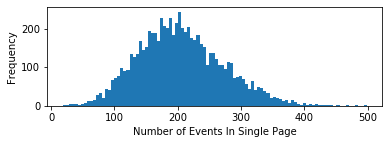

Total Number of Pages by Composer
Mean: 794.5555555555555
Std: 547.6182999764852
Min: 347
Max: 2272


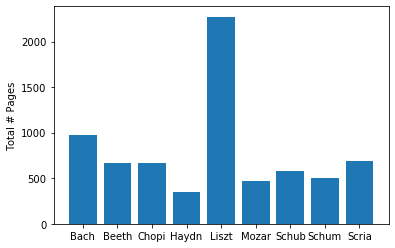

Total Number of Note Events by Composer
Mean: 162904.22222222222
Std: 92578.94143171699
Min: 87957
Max: 394088


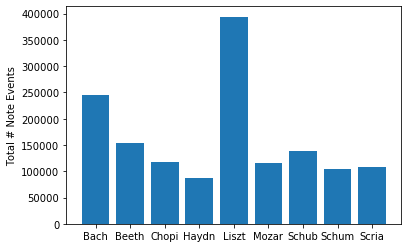

In [9]:
getFeatureStats(feats)

Note that there is a wide variation in the number of features per page and a significant class imbalance in the data.  We will define a proxy task which tries to classify short fixed-length chunks of bootleg score features, and resample the classes to ensure class balance.

In [34]:
394000*.6/128, 88000*.6/64

(1846.875, 825.0)

### Split Data into Train, Validation, & Test

Below we separate the data into train, validation, & test sets.  We split the data by piece (as opposed to page) to ensure total separation.  This data corresponds to the original task of classifying a single page of sheet music.

In [10]:
def splitTrainValidTest(d, train=.6, validation=.2, test=.2, savefile = None):
    
    # shuffle
    assert(train + validation + test == 1.0)
    np.random.seed(0)
    pieceDirs = list(d.keys())
    np.random.shuffle(pieceDirs)
    
    # split
    breakpt1 = int(len(pieceDirs) * train)
    breakpt2 = breakpt1 + int(len(pieceDirs) * validation)
    pieceDirs_train = pieceDirs[0:breakpt1]
    pieceDirs_valid = pieceDirs[breakpt1:breakpt2]
    pieceDirs_test = pieceDirs[breakpt2:]
    
    # save
    d_train = getDataSubset(d, pieceDirs_train)
    d_valid = getDataSubset(d, pieceDirs_valid)
    d_test = getDataSubset(d, pieceDirs_test)
    if savefile:
        saveToPickle([d, pieceDirs_train, pieceDirs_valid, pieceDirs_test], savefile)
    
    return d_train, d_valid, d_test

In [11]:
def getDataSubset(dAll, toKeep):
    dSubset = {}
    for pieceDir in toKeep:
        dSubset[pieceDir] = dAll[pieceDir]
    return dSubset

In [12]:
def saveToPickle(d, outfile):
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [13]:
def loadPickle(infile):
    with open(infile, 'rb') as f:
        d = pickle.load(f)
    return d

In [23]:
save_pages_file = '{}/data.pages.pkl'.format(score_feat_dir)
#d_train, d_valid, d_test = splitTrainValidTest(feats, train=.6, validation=.2, test=.2, savefile=save_pages_file)

### Format data in chunks

Below we prepare the data for the proxy task, which assumes a fixed-length (L=64) chunk of bootleg features.  To ensure class balance, we randomly sample the same number of chunks from each class.

In [21]:
def getComposer2IndexMapping(feat_dir):
    composers = []
    for composerDir in sorted(glob.glob('{}/*/'.format(feat_dir))):
        composer = composerDir.split('/')[-2]
        composers.append(composer)
    c_to_i = {c:i for i, c in enumerate(composers)}
    
    return c_to_i, composers

In [22]:
def getChunkedData_uniformSampling(d, chunkSize, c_to_i):
    '''
    Uniform sampling with 50% overlap.  Doesn't keep page location info.
    '''
    frags = []
    labels = []
    pieceDir2idxRange = {}
    for pieceDir in d:
        merged = np.hstack(d[pieceDir])
        composerIdx = c_to_i[pieceDir.split('/')[-3]]
        startChunkIdx = len(frags)
        for startIdx in range(0, merged.shape[1], chunkSize // 2):
            endIdx = startIdx + chunkSize
            if endIdx <= merged.shape[1]:
                frags.append(merged[:,startIdx:endIdx])
                labels.append(composerIdx)
        endChunkIdx = len(frags)
        pieceDir2idxRange[pieceDir] = (startChunkIdx, endChunkIdx)
    frags = np.array(frags)
    labels = np.array(labels)
    
    return frags, labels, pieceDir2idxRange

In [23]:
def getChunkedData_balanced(d, chunkSize, samplesPerComposer, composers):
    '''
    Samples the same number of windows from each composer to avoid class imbalance.
    Also keeps the page location for debugging and error analysis.
    '''
    np.random.seed(0)
    
    frags = []
    labels = []
    pagelocs = [] # list of (pieceDir, startPage, endPage) tuples
    
    for composerIdx, composer in enumerate(composers):
        samples, locinfo = sampleFromComposer(d, chunkSize, samplesPerComposer, composer)
        frags.extend(samples)
        labels.extend([composerIdx] * samplesPerComposer)
        pagelocs.extend(locinfo)
        
    frags = np.array(frags)
    labels = np.array(labels)
    
    # shuffle indices
    shuffled_idxs = np.arange(len(labels))
    np.random.shuffle(shuffled_idxs)
    frags = frags[shuffled_idxs]
    labels = labels[shuffled_idxs]
    pagelocs = [pagelocs[i] for i in shuffled_idxs]
    
    return frags, labels, pagelocs

In [24]:
def sampleFromComposer(d, chunkSize, N, composer):
    '''
    Samples N windows of length chunkSize from the bootleg score data from the specified composer.
    Returns the sampled data, along with piece & page location for error analysis.
    '''
    
    # generate list of all valid sample locations
    allLocs = [] # list of (pieceNum, offset) tuples
    validPieceDirs = [] # pieceDirs that correspond to this composer
    bscores = [] # list of bootleg scores from each piece
    for pieceDir in d:
        if pieceDir.split('/')[-3] == composer:
            pieceNum = len(validPieceDirs)
            validPageFeats = [elem for elem in d[pieceDir] if elem is not None]
            if len(validPageFeats) == 0:
                continue
            merged = np.hstack(validPageFeats)
            for col_offset in range(merged.shape[1] - chunkSize + 1):
                allLocs.append((pieceNum, col_offset))
            validPieceDirs.append(pieceDir)
            bscores.append(merged)

    # generate samples
    frags = []
    pagelocs = []
    sample_idxs = np.random.choice(len(allLocs), N)
    for sample_idx in sample_idxs:
        pieceNum, offset = allLocs[sample_idx]
        pieceDir = validPieceDirs[pieceNum]
        frag = bscores[pieceNum][:, offset:offset+chunkSize]
        locStart = determinePageLocation(d, pieceDir, offset) # (pageLocFloat, pageNum, pageOffset)
        locEnd = determinePageLocation(d, pieceDir, offset + chunkSize - 1)
        frags.append(frag)
        pagelocs.append((pieceDir, locStart, locEnd))

    return frags, pagelocs

In [25]:
def determinePageLocation(d, pieceDir, offset):
    '''
    Determines the page location of the given bootleg score column offset.  The page location
    is calculated as a floating point number.
    '''
    accum = 0
    pageloc = (-1, -1, -1) # (pageLocFloat, pageNum, pageOffset)
    for pageIdx, elem in enumerate(d[pieceDir]):
        if elem is not None:
            numEvents = elem.shape[1]
            if accum + numEvents > offset:
                frac = (offset - accum) / (numEvents - 1) * 1.0
                pageFloat = pageIdx + frac
                pageloc = (pageFloat, pageIdx, offset - accum) 
                break
            accum += numEvents
    return pageloc

In [26]:
composer2idx, composers = getComposer2IndexMapping(score_feat_dir)

In [62]:
chunkSize = 64 # pick a chunk size a bit larger than 64 to allow for additional data augmentation
samplesPerComposer = 3600
X_train, y_train, pageinfo_train = getChunkedData_balanced(d_train, chunkSize, samplesPerComposer, composers)
X_valid, y_valid, pageinfo_valid = getChunkedData_balanced(d_valid, chunkSize, samplesPerComposer//3, composers)
X_test, y_test, pageinfo_test = getChunkedData_balanced(d_test, chunkSize, samplesPerComposer//3, composers)

In [44]:
X_train.shape, X_valid.shape, X_test.shape

((8100, 62, 256), (2700, 62, 256), (2700, 62, 256))

In [63]:
save_chunks_file = f'{score_feat_dir}/data.chunks{chunkSize}.pkl'
saveToPickle([X_train, y_train, pageinfo_train, X_valid, y_valid, pageinfo_valid, X_test, y_test, pageinfo_test], save_chunks_file)

### Verify data

Compare the bootleg score data chunks against the original png images to verify that the data has been processed correctly.

In [38]:
def visualizeBootlegScore(bs, lines = [13, 15, 17, 19, 21, 35, 37, 39, 41, 43]):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [39]:
def getCorrespondingImage(tup, png_dir = 'data/png', showNext = False):
    pieceDir, startLoc, endLoc = tup
    composer = pieceDir.split('/')[-3]
    pieceID = pieceDir.split('/')[-2]
    startpage = startLoc[1]
    if showNext:
        startpage += 1
    pngfile = '{}/{}/{}/{}-{}.png'.format(png_dir, composer, pieceID, pieceID, startpage)
    im = PIL.Image.open(pngfile)
    return im

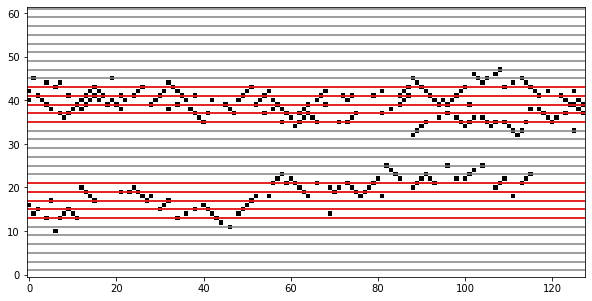

In [40]:
i = 27
visualizeBootlegScore(X_train[i])

In [41]:
pageinfo_train[i]

('score_feat/Bach/01012/',
 (3.383084577114428, 3, 77),
 (4.010869565217392, 4, 2))

In [36]:
im = getCorrespondingImage(pageinfo_train[i], showNext = False)
im

# Prepare data for fastai

In the sections below, we will prepare the data for use with the fastai library.  This is adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
from fastai import *
from fastai.text import *
import glob

In [15]:
bs=48

In [16]:
torch.cuda.set_device(0)

In [17]:
data_path = Config.data_path()

In [18]:
name = 'bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
#lm_fns = ['awdlstm_wt', f'awdlstm_wt_vocab']

### Target Language Model Databunch

Convert the bootleg score features into string representations of decimal integers.  Generate one document per pdf.

In [77]:
path_docs = path/'docs_target'
path_docs.mkdir(exist_ok=True)

In [33]:
def convertBinaryToInt(X):
    mask = np.power(2, np.arange(X.shape[0])).reshape((1,-1))
    ints = np.squeeze(mask @ X).astype(np.uint64)
    return list(ints)

In [79]:
def isValid(matrixList):
    for elem in matrixList:
        if elem is None:
            continue
        else:
            return True
    return False

In [80]:
def generateBootlegStringFiles(bscore_feats_file, outdir):
    '''
    Converts the bootleg score features to string decimal representation, and writes them
    to text files in the specified directory.
    '''
    
    with open(bscore_feats_file, 'rb') as f:
        bscore_feats = pickle.load(f)[0]
        
    for pieceDir in bscore_feats: # e.g. score_feat/Bach/00748/
        pid = pieceDir.split('/')[-2] # 00748
        outfile = outdir/ (pid + '.txt')
        if isValid(bscore_feats[pieceDir]): # has at least one valid page of features
            with open(outfile,'w') as fout:
                for binaryMatrix in bscore_feats[pieceDir]:
                    if binaryMatrix is not None:
                        ints = convertBinaryToInt(binaryMatrix)
                        pageStr = ' '.join([str(i) for i in ints])
                        fout.write(pageStr)
                        fout.write('\n\n')
                fout.write('</doc>')

In [81]:
#generateBootlegStringFiles(save_pages_file, path_docs)

In [82]:
path_docs.ls()[:5]

[PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_target/00756.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_target/438714.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_target/05830.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_target/00774.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_target/01016.txt')]

In [85]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
lm_target_data = (TextList.from_folder(path_docs, processor=[OpenFileProcessor(), TokenizeProcessor(tokenizer=basicTokenizer), NumericalizeProcessor()])
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

lm_target_data.save(path/'lm_target_databunch')

### IMSLP Language Model Databunch

Same as above, but using the entire IMSLP piano bootleg score dataset.

In [100]:
!git clone https://github.com/HMC-MIR/piano_bootleg_scores.git

Cloning into 'piano_bootleg_scores'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 49214 (delta 0), reused 1 (delta 0), pack-reused 49212
Receiving objects: 100% (49214/49214), 88.64 MiB | 13.45 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Checking out files: 100% (31842/31842), done.


In [103]:
imslp_bscores_filelist = 'imslp_bscores.list'
!find piano_bootleg_scores/imslp_bootleg_dir-v1/ -name *.pkl > {imslp_bscores_filelist}

In [104]:
path_docs = path/'docs_imslp'
path_docs.mkdir(exist_ok=True)

In [105]:
def imslp2text(filelist, outdir):
    with open(filelist, 'r') as f:
        for line in f:
            bscorefile = line.strip() # path/to/dest/283513.pkl
            fileid = os.path.splitext(os.path.basename(bscorefile))[0] # e.g. 283513
            outfile = outdir/f'{fileid}.txt'
            bscore2textfile(bscorefile, outfile)

In [106]:
def bscore2textfile(infile, outfile):
    '''
    Converts a bootleg score .pkl file to text and writes to the specified output file.
    '''
    with open(infile, 'rb') as f:
        d = pickle.load(f)
    
    with open(outfile, 'w') as fout:
        for l in d: # each page
            if len(l) > 0:
                pageStr = ' '.join([str(i) for i in l])
                fout.write(pageStr)
                fout.write('\n\n')
        fout.write('</doc>')

In [107]:
imslp2text(imslp_bscores_filelist, path_docs)

In [109]:
path_docs.ls()[:5]

[PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_imslp/283513.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_imslp/382579.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_imslp/382580.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_imslp/382561.txt'),
 PosixPath('/home/tjtsai/.fastai/data/bscore_lm/docs_imslp/382562.txt')]

In [110]:
lm_imslp_data = (TextList.from_folder(path_docs, processor=[OpenFileProcessor(), TokenizeProcessor(tokenizer=basicTokenizer), NumericalizeProcessor()])
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

lm_imslp_data.save(path/'lm_imslp_databunch')

### Classification data

Here we prepare the train.csv, valid.csv, and test.csv files for the proxy classification task.

In [111]:
def generateBootlegCSVFiles(bscore_feats_file, idx2composer, outfile_train, outfile_valid, outfile_test):
    '''
    Generates train.csv and test.csv from bootleg score fragments.
    '''
    with open(bscore_feats_file, 'rb') as f:
        X_train, y_train, _, X_valid, y_valid, _, X_test, y_test, _ = pickle.load(f)
        
    y_train = [idx2composer[idx] for idx in y_train]
    y_valid = [idx2composer[idx] for idx in y_valid]
    y_test = [idx2composer[idx] for idx in y_test]
    
    with open(outfile_train, 'w') as fout:
        fout.write('label,text\n')
        for i in range(X_train.shape[0]):
            ints = convertBinaryToInt(X_train[i,:,:])
            pageStr = ' '.join([str(i) for i in ints])
            fout.write(f'{y_train[i]},')
            fout.write(pageStr)
            fout.write('\n')

    with open(outfile_valid, 'w') as fout:
        fout.write('label,text\n')
        for i in range(X_valid.shape[0]):
            ints = convertBinaryToInt(X_valid[i,:,:])
            pageStr = ' '.join([str(i) for i in ints])
            fout.write(f'{y_valid[i]},')
            fout.write(pageStr)
            fout.write('\n')

    with open(outfile_test, 'w') as fout:
        fout.write('label,text\n')
        for i in range(X_test.shape[0]):
            ints = convertBinaryToInt(X_test[i,:,:])
            pageStr = ' '.join([str(i) for i in ints])
            fout.write(f'{y_test[i]},')
            fout.write(pageStr)
            fout.write('\n')
            
    return

In [112]:
csv_train_file = path/'train.csv'
csv_valid_file = path/'valid.csv'
csv_test_file = path/'test.csv'
generateBootlegCSVFiles(save_chunks_file, composers, csv_train_file, csv_valid_file, csv_test_file)

We also generate csv files for evaluating on the original page classification task.

In [116]:
def generateFullPageCSVFiles(bscore_pages_file, outfile_train, outfile_valid, outfile_test):
    '''
    Generates csv files for the original task of classifying full pages of music.
    '''
    
    with open(bscore_pages_file, 'rb') as f:
        d, pieceDirs_train, pieceDirs_valid, pieceDirs_test = pickle.load(f)
    
    generateFullPageCSV(d, pieceDirs_train, outfile_train)
    generateFullPageCSV(d, pieceDirs_valid, outfile_valid)
    generateFullPageCSV(d, pieceDirs_test, outfile_test)

In [117]:
def generateFullPageCSV(d, keys, outfile):
    
    with open(outfile, 'w') as fout:
        fout.write('label,text\n')
        for pieceDir in keys: # e.g. score_feat/Bach/00748/
            composer = pieceDir.split('/')[-3]
            for m in d[pieceDir]: # d[pieceDir] -> list of binary bootleg score matrices, one per page
                if m is not None:
                    ints = convertBinaryToInt(m)
                    textStr = ' '.join([str(i) for i in ints])
                    fout.write(f'{composer},{textStr}\n')

In [119]:
csv_train_file = path/'train.fullpage.csv'
csv_valid_file = path/'valid.fullpage.csv'
csv_test_file = path/'test.fullpage.csv'
generateFullPageCSVFiles(save_pages_file, csv_train_file, csv_valid_file, csv_test_file)

Finally, we also generate csv files to facilitate evaluating fixed-length classifiers on the full page classification task.  These classifiers will be applied to multiple windows of features, and the predictions will be averaged.

In [34]:
def generateEnsembleCSV(bscore_pages_file, chunkSz, outfile_test):
    '''
    Generates a csv file to facilitate evaluating fixed-length classifiers on the full page classification task.
    Each line in the file corresponds to a fixed-length window of samples within a page.  The predictions from
    all windows within a single page can then be averaged and evaluated.
    '''
    with open(bscore_pages_file, 'rb') as f:
        d, pieceDirs_train, pieceDirs_valid, pieceDirs_test = pickle.load(f)
        
    with open(outfile_test, 'w') as fout:
        fout.write('id,label,text\n')
        for pieceDir in pieceDirs_test: # e.g. score_feat/Bach/00748/
            pieceID = pieceDir.split('/')[-2]
            composer = pieceDir.split('/')[-3]
            for i, m in enumerate(d[pieceDir]): # d[pieceDir] -> list of binary bootleg score matrices, one per page
                if m is not None and m.shape[1] > 0:
                    if m.shape[1] <= chunkSz: # only 1 window
                        ints = convertBinaryToInt(m)
                        textStr = ' '.join([str(i) for i in ints])
                        idString = f'{pieceID}_{i}_0' # id: pieceID_pageIdx_chunkIdx
                        fout.write(f'{idString},{composer},{textStr}\n')
                    else: # multiple windows
                        numWindows = int(np.ceil(m.shape[1]/(chunkSz/2))) - 1 # hop by half the chunk size
                        for j in range(numWindows - 1):
                            startIdx = chunkSz // 2 * j
                            endIdx = startIdx + chunkSz
                            ints = convertBinaryToInt(m[:,startIdx:endIdx])
                            textStr = ' '.join([str(i) for i in ints])
                            idString = f'{pieceID}_{i}_{j}' # id: pieceID_pageIdx_chunkIdx
                            fout.write(f'{idString},{composer},{textStr}\n')
                        # handle last window
                        ints = convertBinaryToInt(m[:,-chunkSz:])
                        textStr = ' '.join([str(i) for i in ints])
                        idString = f'{pieceID}_{i}_{numWindows-1}' 
                        fout.write(f'{idString},{composer},{textStr}\n')

In [35]:
csv_test_file = path/'test.ensemble64.csv'
generateEnsembleCSV(save_pages_file, 64, csv_test_file)

In [ ]:
lm_target_data = load_data(path, 'lm_target_databunch', bs=bs)

In [99]:
train_df = pd.read_csv(csv_train_file)
valid_df = pd.read_csv(csv_valid_file)
test_df = pd.read_csv(csv_test_file)
clas_target_data_train = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer,
                                               vocab=lm_target_data.vocab, bs=bs, num_workers=1)
clas_target_data_train.save(f'clas_target_databunch_train')